## Import libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import torchvision
from torchvision import models
import torch.optim as optim
import pandas as pd
import numpy as np
import cv2
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
import time
from tqdm import tqdm

In [3]:
from pathlib import Path
import urllib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageOps
import random

## Download Dataset

In [2]:
%pip install kagglehub

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dansbecker/food-101")

print("Path to dataset files:", path)

100%|██████████| 9.38G/9.38G [06:28<00:00, 25.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1


In [4]:
!mv /root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1 /content/
!mv /content/1/food-101 /content
!rm -rv 1
!rm -rv food-101/_*

In [7]:
input_root_dir = "./food-101/food-101"
input_root_path = Path(input_root_dir)
print(os.listdir(input_root_dir))
image_dir_path = input_root_path/'images'

['.DS_Store', 'README.txt', 'images', 'Classification2_raw.ipynb', 'meta', 'license_agreement.txt']


In [9]:
%cat {input_root_dir}/README.txt

Readme

Structure:
----------
pec/
    images/
        <class_name>/
            <image_id>.jpg
    meta/
        classes.txt
        labels.txt
        test.json
        test.txt
        train.json
        train.txt

All images can be found in the "images" folder and are organized per class. All
image ids are unique and correspond to the foodspotting.com review ids. Thus
the original articles can retrieved trough
  http://www.foodspotting.com/reviews/<image_id>
or through the foodspotting api (http://www.foodspotting.com/api).

The test/train splitting used in the experiment of our paper, can be found in
the "meta" directory.

For any questions contact bossard@vision.ee.ethz.ch



## TODO: Preprocess Dataset

In [8]:
class_path = input_root_dir+'/meta/classes.txt'
train_img_name_path = input_root_dir+'/meta/train.txt'
test_img_name_path = input_root_dir+'/meta/test.txt'

In [9]:
def file2list(path):
    file1 = open(path,'r')
    lines = file1.readlines()
    final_list = [line.strip() for line in lines]
    return final_list

In [10]:
classes = file2list(class_path)
train_data = file2list(train_img_name_path)
test_data = file2list(test_img_name_path)
le = preprocessing.LabelEncoder()
targets = le.fit_transform(classes)

In [11]:
classes

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [12]:
print(train_data[0:5])
print(len(train_data))

['apple_pie/1005649', 'apple_pie/1014775', 'apple_pie/1026328', 'apple_pie/1028787', 'apple_pie/1043283']
75750


In [22]:
# TODO: compelete this using implementation detail (20 mins)
class FoodData(Dataset):
    def __init__(self,img_paths,img_dir,size,transform=None):
      self.img_paths = img_paths
      self.img_dir = img_dir
      self.size = size
      self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self,index):
        file_name = self.img_paths[index]
        cls_name, img_index = file_name.split('/')
        file_name = f"{img_index}.jpg"
        image_path = os.path.join(self.img_dir, 'images', cls_name, file_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.size, self.size))

        if self.transform:
            img = self.transform(img)
        
        label = le.transform([cls_name])[0]

        return {"gt": img, "label": torch.tensor(label)}

## Augmentations

### AutoAugment

In [53]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random


class ImageNetPolicy(object):
    """ Randomly choose one of the best 24 Sub-policies on ImageNet.
        Example:
        >>> policy = ImageNetPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     ImageNetPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.4, "posterize", 8, 0.6, "rotate", 9, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "posterize", 7, 0.6, "posterize", 6, fillcolor),
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),

            SubPolicy(0.4, "equalize", 4, 0.8, "rotate", 8, fillcolor),
            SubPolicy(0.6, "solarize", 3, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.8, "posterize", 5, 1.0, "equalize", 2, fillcolor),
            SubPolicy(0.2, "rotate", 3, 0.6, "solarize", 8, fillcolor),
            SubPolicy(0.6, "equalize", 8, 0.4, "posterize", 6, fillcolor),

            SubPolicy(0.8, "rotate", 8, 0.4, "color", 0, fillcolor),
            SubPolicy(0.4, "rotate", 9, 0.6, "equalize", 2, fillcolor),
            SubPolicy(0.0, "equalize", 7, 0.8, "equalize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),

            SubPolicy(0.8, "rotate", 8, 1.0, "color", 2, fillcolor),
            SubPolicy(0.8, "color", 8, 0.8, "solarize", 7, fillcolor),
            SubPolicy(0.4, "sharpness", 7, 0.6, "invert", 8, fillcolor),
            SubPolicy(0.6, "shearX", 5, 1.0, "equalize", 9, fillcolor),
            SubPolicy(0.4, "color", 0, 0.6, "equalize", 3, fillcolor),

            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment ImageNet Policy"


class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.
        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"


class SVHNPolicy(object):
    """ Randomly choose one of the best 25 Sub-policies on SVHN.
        Example:
        >>> policy = SVHNPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     SVHNPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.9, "shearX", 4, 0.2, "invert", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.7, "invert", 5, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.6, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 3, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "equalize", 1, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.8, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.4, "invert", 5, fillcolor),
            SubPolicy(0.9, "shearY", 5, 0.2, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 6, 0.8, "autocontrast", 1, fillcolor),
            SubPolicy(0.6, "equalize", 3, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.3, "solarize", 3, fillcolor),
            SubPolicy(0.8, "shearY", 8, 0.7, "invert", 4, fillcolor),
            SubPolicy(0.9, "equalize", 5, 0.6, "translateY", 6, fillcolor),
            SubPolicy(0.9, "invert", 4, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.3, "contrast", 3, 0.8, "rotate", 4, fillcolor),

            SubPolicy(0.8, "invert", 5, 0.0, "translateY", 2, fillcolor),
            SubPolicy(0.7, "shearY", 6, 0.4, "solarize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.3, "shearY", 7, 0.9, "translateX", 3, fillcolor),
            SubPolicy(0.1, "shearX", 6, 0.6, "invert", 5, fillcolor),

            SubPolicy(0.7, "solarize", 2, 0.6, "translateY", 7, fillcolor),
            SubPolicy(0.8, "shearY", 4, 0.8, "invert", 8, fillcolor),
            SubPolicy(0.7, "shearX", 9, 0.8, "translateY", 3, fillcolor),
            SubPolicy(0.8, "shearY", 5, 0.7, "autocontrast", 3, fillcolor),
            SubPolicy(0.7, "shearX", 2, 0.1, "invert", 5, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment SVHN Policy"


class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        # from https://stackoverflow.com/questions/5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
        def rotate_with_fill(img, magnitude):
            rot = img.convert("RGBA").rotate(magnitude)
            return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

        func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fillcolor=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1])),
                fillcolor=fillcolor),
            "rotate": lambda img, magnitude: rotate_with_fill(img, magnitude),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: ImageOps.equalize(img),
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]


    def __call__(self, img):
        if random.random() < self.p1: img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2: img = self.operation2(img, self.magnitude2)
        return img

### visualization of augmentation

In [50]:
# Dataset and DataLoader setup
vis_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

vis_dataset = FoodData(train_data, input_root_dir, size=256, transform=vis_transforms)
vis_loader = DataLoader(vis_dataset, batch_size=64, shuffle=True)

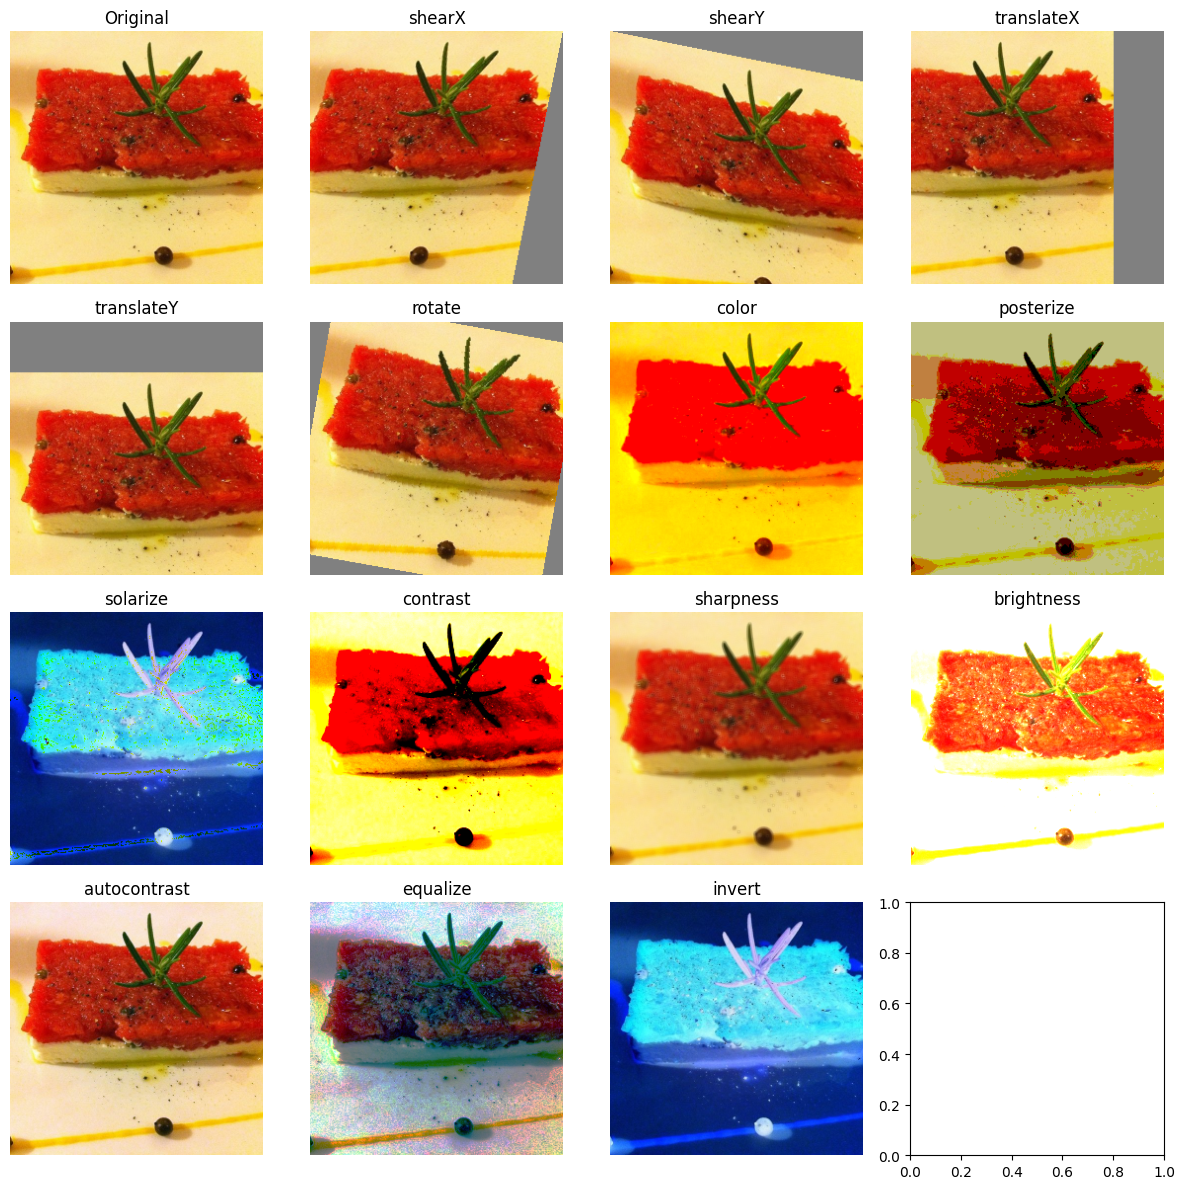

In [51]:
# Define fill color and augmentation functions
fillcolor = (128, 128, 128)
func = {
    "Original": lambda img, magnitude: img,  # For displaying the original image
    "shearX": lambda img, magnitude: img.transform(
        img.size, Image.AFFINE, (1, 0.1 * magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
        Image.BICUBIC, fillcolor=fillcolor),
    "shearY": lambda img, magnitude: img.transform(
        img.size, Image.AFFINE, (1, 0, 0, 0.1 * magnitude * random.choice([-1, 1]), 1, 0),
        Image.BICUBIC, fillcolor=fillcolor),
    "translateX": lambda img, magnitude: img.transform(
        img.size, Image.AFFINE, (1, 0, 0.1 * magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
        fillcolor=fillcolor),
    "translateY": lambda img, magnitude: img.transform(
        img.size, Image.AFFINE, (1, 0, 0, 0, 1, 0.1 * magnitude * img.size[1] * random.choice([-1, 1])),
        fillcolor=fillcolor),
    "rotate": lambda img, magnitude: img.rotate(5*magnitude * random.choice([-1, 1]), fillcolor=fillcolor),
    "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
    "posterize": lambda img, magnitude: ImageOps.posterize(img, int(magnitude)),
    "solarize": lambda img, magnitude: ImageOps.solarize(img, int(magnitude)),
    "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
        1 + magnitude * random.choice([-1, 1])),
    "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
        1 + magnitude * random.choice([-1, 1])),
    "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
        1 + magnitude * random.choice([-1, 1])),
    "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
    "equalize": lambda img, magnitude: ImageOps.equalize(img),
    "invert": lambda img, magnitude: ImageOps.invert(img)
}

# Define the magnitude for augmentations
magnitude = 2

# Function to visualize augmentations in a 4x4 grid
def vis_augmentations(image, augmentations, magnitude):
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))
    axs = axs.flatten()

    # Loop through each augmentation, including the original image
    for i, (name, augment) in enumerate(augmentations.items()):
        if i >= 16:  # Limit display to 16 augmentations
            break

        # Apply augmentation
        augmented_image = augment(image, magnitude)

        # Display augmented image
        axs[i].imshow(augmented_image)
        axs[i].set_title(name)
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()

# Load a batch from the dataloader and unnormalize the first image
dataiter = iter(vis_loader)
images = next(dataiter)['gt']

# Unnormalize the images
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
images = images * std + mean

# Convert the first image in the batch to PIL format
sample_image = transforms.ToPILImage()(images[0])

# Visualize augmentations
vis_augmentations(sample_image, func, magnitude)


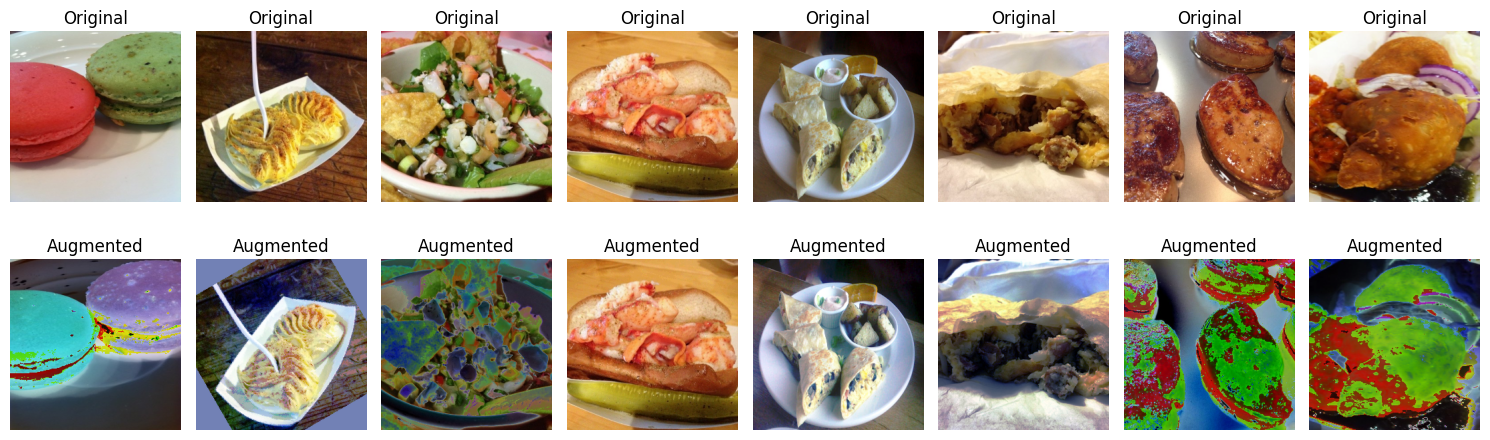

In [54]:
# Define augmentation policies
imagenet_policy = ImageNetPolicy()
cifar10_policy = CIFAR10Policy()
svhn_policy = SVHNPolicy()

# Choose a random policy to apply to the images
policies = [imagenet_policy]

# Function to apply a random policy from the policies list to an image
def apply_random_policy(img):
    policy = random.choice(policies)
    return policy(img)

# Unnormalize the images using mean and std, suitable for ImageNet-style normalization
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    return img_tensor * std + mean

# Function to visualize original and augmented images in a grid
def visualize_augmentations(data_loader, num_images=8):
    # Load a batch of images from the data loader
    data_iter = iter(data_loader)
    images = next(data_iter)['gt']  # Assuming 'gt' key for images

    # Unnormalize images for display
    images = unnormalize(images)

    # Set up plot for original and augmented images
    fig, axs = plt.subplots(2, num_images, figsize=(15, 5))

    for i in range(num_images):
        # Original Image
        img = transforms.ToPILImage()(images[i])
        axs[0, i].imshow(img)
        axs[0, i].set_title("Original")
        axs[0, i].axis("off")

        # Augmented Image
        augmented_img = apply_random_policy(img)
        axs[1, i].imshow(augmented_img)
        axs[1, i].set_title("Augmented")
        axs[1, i].axis("off")

    plt.tight_layout()
    plt.show()

# Run visualization on a batch of training data
visualize_augmentations(vis_loader)

### some good augmentations

In [ ]:
augmentation_pipeline = A.Compose(
    [
        A.HorizontalFlip(p = 0.5), # apply horizontal flip to 50% of images
        A.VerticalFlip(p =0.5),
        A.OneOf(
            [
                # apply one of transforms to 50% of images
                A.RandomGamma(), # apply random gamma
                A.CLAHE(), # apply random brightness
                A.RandomBrightnessContrast(),
            ],
            p = 0.5
        ),
        A.CoarseDropout(max_holes=10, max_height=20, max_width=20, fill_value=0, p=0.5),
        A.Blur(blur_limit=(15, 15), p=0.5),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),

        ToTensor() # convert the image to PyTorch tensor
    ],
    p = 1
)
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(90),
#     transforms.CenterCrop(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(),
    ImageNetPolicy(),
    transforms.ToTensor(),
    transforms.Normalize( mean = np.array([0.485, 0.456, 0.406]),
    std = np.array([0.229, 0.224, 0.225]))
])
train_transforms = transforms.Compose([transforms.ToPILImage(),
                                        transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

## Data Loader

In [23]:
# from autoaugment import ImageNetPolicy
from albumentations.pytorch.transforms import ToTensorV2 as ToTensor
import albumentations as A


transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize( mean = np.array([0.485, 0.456, 0.406]),
    std = np.array([0.229, 0.224, 0.225]))
])

train_dataset = FoodData(train_data,input_root_dir,256,transforms_train)

In [25]:
batch_size = 64
valid_size = 0.2

# Determine the sizes for train and validation sets
num_train = int((1 - valid_size) * len(train_data))
num_valid = len(train_data) - num_train

# Split the dataset
train_dataset, valid_dataset = random_split(train_dataset, [num_train, num_valid])

# Create DataLoaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [26]:
dataloaders = {
    'train': train_loader,
    'val': valid_loader
}
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(valid_dataset)
}

## TODO: Training Script

In [32]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        if val != np.nan and val != np.inf:
            self.val = val
            self.sum += val * n
            self.count += n
            self.avg = self.sum / self.count

In [80]:
#TODO define your model, optimizer, scheduler, and criterion here! (5 mins)
from torchvision import models 

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model_ft = models.resnet50(pretrained=True)
model_ft.fc = nn.Linear(2048, 101)
model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

'''
fc_params = {}
other_params = {}

for name, param in model_ft.named_parameters():
    if 'fc' in name:
        fc_params[name] = param
    else:
        other_params[name] = param

fc_params = list(fc_params.values())
other_params = list(other_params.values())

# Now, define the optimizer
optimizer = torch.optim.Adam(
    [
        {"params": fc_params, "lr": args.lr},  # Apply specific lr to the fc layer
        {"params": other_params}  # Apply default lr to the rest of the model
    ],
    lr=1e-4, weight_decay=args.weight_decay
)



sched = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8, 16, 24], gamma=0.2)
'''

/localhome/aaa324/conda/conda/envs/FeatUp/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/localhome/aaa324/conda/conda/envs/FeatUp/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


'\nfc_params = {}\nother_params = {}\n\nfor name, param in model_ft.named_parameters():\n    if \'fc\' in name:\n        fc_params[name] = param\n    else:\n        other_params[name] = param\n\nfc_params = list(fc_params.values())\nother_params = list(other_params.values())\n\n# Now, define the optimizer\noptimizer = torch.optim.Adam(\n    [\n        {"params": fc_params, "lr": args.lr},  # Apply specific lr to the fc layer\n        {"params": other_params}  # Apply default lr to the rest of the model\n    ],\n    lr=1e-4, weight_decay=args.weight_decay\n)\n\n\n\nsched = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8, 16, 24], gamma=0.2)\n'

In [81]:
#TODO use implementation detail slides to train your model with the above augmentations (45 mins)


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  best_acc = 0.0

  for epoch in range(num_epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      elif phase == 'val':
        model.eval()

      loss_total = AverageMeter()
      correct_predictions_total = 0
      num_samples = 0

      for ind, data in enumerate(tqdm(dataloaders[phase])):   
         inputs, labels = data['gt'].to(device), data['label'].to(device)

         optimizer.zero_grad()
         with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()
          
          loss_total.update(loss)

          preds = outputs.argmax(dim=1)
          correct_predictions = torch.sum(preds==labels)
          correct_predictions_total += correct_predictions.item()
          num_samples += data['gt'].shape[0]

          if ind % 300 == 0:
            print(f'{ind} / {dataset_sizes[phase]//64} Loss: {loss_total.avg} Acc: {100*correct_predictions_total/num_samples}')
      
      acc_total = correct_predictions_total / dataset_sizes[phase]
      print(f"{phase} Epoch: {epoch} Loss: {loss_total.avg:.4f} Acc: {100*acc_total:.4f}")
      if phase == 'val':
        if acc_total >= best_acc:
          best_acc = acc_total
          torch.save(model.state_dict(), 'best_model_so_far.pth')
      
      if phase == 'train':
        scheduler.step()
        
  model.load_state_dict(torch.load('best_model_so_far.pth'))
  return model


model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

  0%|          | 0/947 [00:00<?, ?it/s]

  0%|          | 1/947 [00:00<05:11,  3.04it/s]

0 / 946 Loss: 4.705087184906006 Acc: 1.5625


 32%|███▏      | 301/947 [01:27<03:07,  3.44it/s]

300 / 946 Loss: 2.68119478225708 Acc: 36.03612956810631


 63%|██████▎   | 601/947 [02:54<01:40,  3.43it/s]

600 / 946 Loss: 2.3243484497070312 Acc: 42.92325291181364


 95%|█████████▌| 901/947 [04:22<00:13,  3.37it/s]

900 / 946 Loss: 2.141171455383301 Acc: 46.88367092119867


100%|██████████| 947/947 [04:36<00:00,  3.43it/s]


train Epoch: 0 Loss: 2.1189 Acc: 47.3333


  1%|          | 2/237 [00:00<00:42,  5.50it/s]

0 / 236 Loss: 1.9922741651535034 Acc: 45.3125


100%|██████████| 237/237 [00:43<00:00,  5.45it/s]


val Epoch: 0 Loss: 1.9645 Acc: 50.7657


  0%|          | 1/947 [00:00<05:19,  2.96it/s]

0 / 946 Loss: 1.8102773427963257 Acc: 51.5625


 32%|███▏      | 301/947 [01:27<03:07,  3.45it/s]

300 / 946 Loss: 1.5240142345428467 Acc: 60.19518272425249


 63%|██████▎   | 601/947 [02:54<01:39,  3.46it/s]

600 / 946 Loss: 1.527825117111206 Acc: 60.22774542429285


 95%|█████████▌| 901/947 [04:21<00:13,  3.42it/s]

900 / 946 Loss: 1.5056533813476562 Acc: 60.686043285238625


100%|██████████| 947/947 [04:35<00:00,  3.44it/s]


train Epoch: 1 Loss: 1.5010 Acc: 60.7211


  1%|          | 2/237 [00:00<00:42,  5.54it/s]

0 / 236 Loss: 1.6792680025100708 Acc: 56.25


100%|██████████| 237/237 [00:43<00:00,  5.49it/s]


val Epoch: 1 Loss: 1.7127 Acc: 56.1518


  0%|          | 1/947 [00:00<05:16,  2.99it/s]

0 / 946 Loss: 1.5985409021377563 Acc: 57.8125


 32%|███▏      | 301/947 [01:27<03:08,  3.43it/s]

300 / 946 Loss: 1.279645323753357 Acc: 66.32059800664452


 63%|██████▎   | 601/947 [02:54<01:41,  3.41it/s]

600 / 946 Loss: 1.292739987373352 Acc: 65.8589850249584


 95%|█████████▌| 901/947 [04:22<00:13,  3.42it/s]

900 / 946 Loss: 1.293320655822754 Acc: 65.95969755826859


100%|██████████| 947/947 [04:35<00:00,  3.43it/s]


train Epoch: 2 Loss: 1.2918 Acc: 65.9670


  1%|          | 2/237 [00:00<00:42,  5.52it/s]

0 / 236 Loss: 1.2852635383605957 Acc: 64.0625


100%|██████████| 237/237 [00:43<00:00,  5.48it/s]


val Epoch: 2 Loss: 1.4495 Acc: 62.0000


  0%|          | 1/947 [00:00<05:07,  3.08it/s]

0 / 946 Loss: 0.7662636041641235 Acc: 71.875


 32%|███▏      | 301/947 [01:27<03:08,  3.43it/s]

300 / 946 Loss: 0.9041576385498047 Acc: 75.64887873754152


 63%|██████▎   | 601/947 [02:54<01:40,  3.43it/s]

600 / 946 Loss: 0.8630706071853638 Acc: 76.86408069883528


 95%|█████████▌| 901/947 [04:22<00:13,  3.38it/s]

900 / 946 Loss: 0.8419349789619446 Acc: 77.28565482796893


100%|██████████| 947/947 [04:36<00:00,  3.43it/s]


train Epoch: 3 Loss: 0.8385 Acc: 77.3614


  1%|          | 2/237 [00:00<00:42,  5.47it/s]

0 / 236 Loss: 0.8245767951011658 Acc: 78.125


100%|██████████| 237/237 [00:43<00:00,  5.45it/s]


val Epoch: 3 Loss: 0.9464 Acc: 74.8185


  0%|          | 1/947 [00:00<05:15,  2.99it/s]

0 / 946 Loss: 0.9805178046226501 Acc: 71.875


 32%|███▏      | 301/947 [01:27<03:09,  3.42it/s]

300 / 946 Loss: 0.7307502627372742 Acc: 80.04568106312293


 63%|██████▎   | 601/947 [02:55<01:40,  3.43it/s]

600 / 946 Loss: 0.7250640988349915 Acc: 80.19446755407654


 95%|█████████▌| 901/947 [04:22<00:13,  3.41it/s]

900 / 946 Loss: 0.7218912839889526 Acc: 80.23897058823529


100%|██████████| 947/947 [04:35<00:00,  3.43it/s]


train Epoch: 4 Loss: 0.7223 Acc: 80.2343


  1%|          | 2/237 [00:00<00:43,  5.39it/s]

0 / 236 Loss: 0.8523704409599304 Acc: 78.125


100%|██████████| 237/237 [00:43<00:00,  5.48it/s]


val Epoch: 4 Loss: 0.9064 Acc: 75.9142


  0%|          | 1/947 [00:00<05:14,  3.01it/s]

0 / 946 Loss: 0.8427046537399292 Acc: 76.5625


 32%|███▏      | 301/947 [01:27<03:07,  3.44it/s]

300 / 946 Loss: 0.6630746126174927 Acc: 81.66528239202658


 63%|██████▎   | 601/947 [02:55<01:43,  3.34it/s]

600 / 946 Loss: 0.6685710549354553 Acc: 81.50478369384359


 95%|█████████▌| 901/947 [04:22<00:13,  3.40it/s]

900 / 946 Loss: 0.6745235919952393 Acc: 81.35578523862375


100%|██████████| 947/947 [04:36<00:00,  3.43it/s]


train Epoch: 5 Loss: 0.6753 Acc: 81.3333


  1%|          | 2/237 [00:00<00:42,  5.57it/s]

0 / 236 Loss: 0.8358215689659119 Acc: 81.25


100%|██████████| 237/237 [00:43<00:00,  5.44it/s]


val Epoch: 5 Loss: 0.8904 Acc: 76.2310


  0%|          | 1/947 [00:00<05:19,  2.96it/s]

0 / 946 Loss: 0.8859508037567139 Acc: 76.5625


 32%|███▏      | 301/947 [01:27<03:07,  3.44it/s]

300 / 946 Loss: 0.6128394603729248 Acc: 83.05128737541528


 63%|██████▎   | 601/947 [02:55<01:40,  3.43it/s]

600 / 946 Loss: 0.6223499774932861 Acc: 82.92169301164725


 95%|█████████▌| 901/947 [04:23<00:13,  3.41it/s]

900 / 946 Loss: 0.6203166842460632 Acc: 82.95817147613762


100%|██████████| 947/947 [04:36<00:00,  3.42it/s]


train Epoch: 6 Loss: 0.6205 Acc: 82.9637


  1%|          | 2/237 [00:00<00:42,  5.48it/s]

0 / 236 Loss: 0.7911165356636047 Acc: 79.6875


100%|██████████| 237/237 [00:43<00:00,  5.45it/s]


val Epoch: 6 Loss: 0.8741 Acc: 76.9439


  0%|          | 1/947 [00:00<04:46,  3.31it/s]

0 / 946 Loss: 0.850534200668335 Acc: 76.5625


 32%|███▏      | 301/947 [01:27<03:06,  3.46it/s]

300 / 946 Loss: 0.6051691770553589 Acc: 83.1654900332226


 63%|██████▎   | 601/947 [02:55<01:40,  3.46it/s]

600 / 946 Loss: 0.6112136244773865 Acc: 83.13747920133112


 95%|█████████▌| 901/947 [04:22<00:13,  3.41it/s]

900 / 946 Loss: 0.6130462884902954 Acc: 83.03274139844618


100%|██████████| 947/947 [04:35<00:00,  3.43it/s]


train Epoch: 7 Loss: 0.6124 Acc: 83.0561


  1%|          | 2/237 [00:00<00:42,  5.48it/s]

0 / 236 Loss: 0.9168004393577576 Acc: 78.125


100%|██████████| 237/237 [00:43<00:00,  5.47it/s]


val Epoch: 7 Loss: 0.8636 Acc: 77.0957


  0%|          | 1/947 [00:00<05:14,  3.01it/s]

0 / 946 Loss: 0.6189723610877991 Acc: 85.9375


 32%|███▏      | 301/947 [01:27<03:08,  3.43it/s]

300 / 946 Loss: 0.5969347357749939 Acc: 83.56519933554817


 63%|██████▎   | 601/947 [02:55<01:40,  3.43it/s]

600 / 946 Loss: 0.60260409116745 Acc: 83.397462562396


 95%|█████████▌| 901/947 [04:22<00:13,  3.42it/s]

900 / 946 Loss: 0.6027196049690247 Acc: 83.39692008879024


100%|██████████| 947/947 [04:35<00:00,  3.43it/s]


train Epoch: 8 Loss: 0.6041 Acc: 83.3713


  1%|          | 2/237 [00:00<00:43,  5.39it/s]

0 / 236 Loss: 0.9170668125152588 Acc: 73.4375


100%|██████████| 237/237 [00:43<00:00,  5.45it/s]


val Epoch: 8 Loss: 0.8714 Acc: 76.6667


  0%|          | 1/947 [00:00<04:41,  3.36it/s]

0 / 946 Loss: 0.2893929183483124 Acc: 89.0625


 32%|███▏      | 301/947 [01:27<03:06,  3.46it/s]

300 / 946 Loss: 0.5952395796775818 Acc: 83.95452657807309


 63%|██████▎   | 601/947 [02:55<01:40,  3.45it/s]

600 / 946 Loss: 0.5996558666229248 Acc: 83.67564475873544


 95%|█████████▌| 901/947 [04:22<00:13,  3.45it/s]

900 / 946 Loss: 0.6011592745780945 Acc: 83.57900943396227


100%|██████████| 947/947 [04:36<00:00,  3.43it/s]


train Epoch: 9 Loss: 0.6011 Acc: 83.5578


  1%|          | 2/237 [00:00<00:43,  5.37it/s]

0 / 236 Loss: 0.8672295808792114 Acc: 81.25


100%|██████████| 237/237 [00:43<00:00,  5.42it/s]

val Epoch: 9 Loss: 0.8746 Acc: 76.9637


## Evaluation

### Test-Time Augmentation

In [75]:
%pip install ttach

Note: you may need to restart the kernel to use updated packages.


In [82]:
import ttach as tta
transforms = tta.Compose(
    [
    # tta.FiveCrops(128,128),
    tta.HorizontalFlip(),
    tta.VerticalFlip(),
    # tta.FiveCrops(128,128),
    tta.Rotate90(angles=[0, 90]),
#     tta.Scale(scales=[1, 2, 4]),

    ]
)
model_ft.load_state_dict(torch.load('best_model_so_far.pth'))
model_ft.eval()
tta_model = tta.ClassificationTTAWrapper(model_ft, transforms,merge_mode='mean')

### Accuracy on Test Dataset

In [83]:
correct = 0
total = 0
pred_list = []
correct_list = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for images in tqdm(valid_loader):
        data = images['gt'].squeeze(0).to(device)
        target = images['label'].to(device)
        outputs = model_ft(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        pr = predicted.detach().cpu().numpy()
        for i in pr:
          pred_list.append(i)
        tg = target.detach().cpu().numpy()
        for i in tg:
          correct_list.append(i)
        correct += (predicted == target).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))

100%|██████████| 237/237 [00:43<00:00,  5.42it/s]

Accuracy of the network on the 10000 test images: 77.062706 %
